# RQ4: How frequently do developers use the conversion functions?


In [20]:
import pandas as pd
from pathlib import Path
# Load the dataset
df = pd.read_csv(Path('../../data/sfconvertbot_pr_metadata.csv'))
# set NaN values to None
df = df.where(pd.notnull(df), None)
df

,model_id,pr_url,time,discussion_metadata,header_metadata
0,julien-c/hotdog-not-hotdog,https://huggingface.co/julien-c/hotdog-not-hot...,2022-11-07 14:00:58.522127,"{""apiBaseUrl"":""/api/models/julien-c/hotdog-not...","{""discussion"":{""_id"":""63690187da9b693c272fa24b..."
1,julien-c/hotdog-not-hotdog,https://huggingface.co/julien-c/hotdog-not-hot...,2022-11-07 13:08:07.639102,"{""apiBaseUrl"":""/api/models/julien-c/hotdog-not...","{""discussion"":{""_id"":""6369033585fef3ca96e226c1..."
2,Bingsu/clip-vit-base-patch32-ko,https://huggingface.co/Bingsu/clip-vit-base-pa...,2022-11-08 11:01:01.873169,"{""apiBaseUrl"":""/api/models/Bingsu/clip-vit-bas...","{""discussion"":{""_id"":""636a36ebfbc31ee68fee9d2d..."
3,bert-base-uncased,https://huggingface.co/bert-base-uncased/discu...,2022-11-10 09:35:58.379451,"{""apiBaseUrl"":""/api/models/google-bert/bert-ba...","{""discussion"":{""_id"":""636cc5fcdd7265f81aa0e280..."
4,Norod78/hebrew-gpt_neo-small,https://huggingface.co/Norod78/hebrew-gpt_neo-...,2022-11-10 10:34:42.960641,"{""apiBaseUrl"":""/api/models/Norod78/hebrew-gpt_...","{""discussion"":{""_id"":""636cd3c0d963c5679361edd2..."
...,...,...,...,...,...
8328,marianna13/bert-multilingual-sentiment,https://huggingface.co/marianna13/bert-multili...,2023-04-05 17:20:08.184733,"{""apiBaseUrl"":""/api/models/marianna13/bert-mul...","{""discussion"":{""_id"":""642d91a632bdf5af73e9e307..."
8329,tanoManzo/minilm-attitude-few10p,https://huggingface.co/tanoManzo/minilm-attitu...,2023-04-05 17:22:17.331096,"{""apiBaseUrl"":""/api/models/tanoManzo/minilm-at...","{""discussion"":{""_id"":""642d922425c08a2cb4ba72b3..."
8330,reshinthadith/instruct-codegen-350M-multi,https://huggingface.co/reshinthadith/instruct-...,2023-04-05 17:25:11.641138,"{""apiBaseUrl"":""/api/models/reshinthadith/instr...","{""discussion"":{""_id"":""642d92cb42b094c91388a8bd..."
8331,ArisuNguyen/bart_finetuned_5e_5,https://huggingface.co/ArisuNguyen/bart_finetu...,2023-04-05 17:27:40.223615,"{""apiBaseUrl"":""/api/models/ArisuNguyen/bart_fi...","{""discussion"":{""_id"":""642d936a25c08a2cb4ba8dbc..."


In [38]:
from tqdm import tqdm
import json

# Extract status changes from discussion metadata
for index, row in tqdm(df.iterrows(), total=len(df)):
    status_changes = []
    df.at[index, 'conflicts'] = ""
    try:
        discussion_metadata = json.loads(row['discussion_metadata'])
        for event in discussion_metadata['discussion']['events']:
            event_type = event['type']
            if event_type == 'status-change':
                status_changes.append(event['data']['status'])
    except:
        pass
    try:
        header_metadata = json.loads(row['header_metadata'])
        df.at[index, 'status'] = header_metadata['discussion']['status']
        # check if there are conflicting files
        conflicting_files = header_metadata['discussion']['filesWithConflicts']
        df.at[index, 'conflicts'] = ";".join(conflicting_files)
    except:
        pass
    
    # add a column to track status changes
    df.at[index, 'status_changes'] = ";".join(status_changes)
df


100%|██████████| 7821/7821 [00:02<00:00, 2615.82it/s]


,model_id,pr_url,time,discussion_metadata,header_metadata,status_changes,status,conflicts
0,julien-c/hotdog-not-hotdog,https://huggingface.co/julien-c/hotdog-not-hot...,2022-11-07 14:00:58.522127,"{""apiBaseUrl"":""/api/models/julien-c/hotdog-not...","{""discussion"":{""_id"":""63690187da9b693c272fa24b...",closed,closed,
1,julien-c/hotdog-not-hotdog,https://huggingface.co/julien-c/hotdog-not-hot...,2022-11-07 13:08:07.639102,"{""apiBaseUrl"":""/api/models/julien-c/hotdog-not...","{""discussion"":{""_id"":""6369033585fef3ca96e226c1...",,open,
2,Bingsu/clip-vit-base-patch32-ko,https://huggingface.co/Bingsu/clip-vit-base-pa...,2022-11-08 11:01:01.873169,"{""apiBaseUrl"":""/api/models/Bingsu/clip-vit-bas...","{""discussion"":{""_id"":""636a36ebfbc31ee68fee9d2d...",merged,merged,
3,bert-base-uncased,https://huggingface.co/bert-base-uncased/discu...,2022-11-10 09:35:58.379451,"{""apiBaseUrl"":""/api/models/google-bert/bert-ba...","{""discussion"":{""_id"":""636cc5fcdd7265f81aa0e280...",merged,merged,
4,Norod78/hebrew-gpt_neo-small,https://huggingface.co/Norod78/hebrew-gpt_neo-...,2022-11-10 10:34:42.960641,"{""apiBaseUrl"":""/api/models/Norod78/hebrew-gpt_...","{""discussion"":{""_id"":""636cd3c0d963c5679361edd2...",merged,merged,
...,...,...,...,...,...,...,...,...
8328,marianna13/bert-multilingual-sentiment,https://huggingface.co/marianna13/bert-multili...,2023-04-05 17:20:08.184733,"{""apiBaseUrl"":""/api/models/marianna13/bert-mul...","{""discussion"":{""_id"":""642d91a632bdf5af73e9e307...",,open,
8329,tanoManzo/minilm-attitude-few10p,https://huggingface.co/tanoManzo/minilm-attitu...,2023-04-05 17:22:17.331096,"{""apiBaseUrl"":""/api/models/tanoManzo/minilm-at...","{""discussion"":{""_id"":""642d922425c08a2cb4ba72b3...",,open,
8330,reshinthadith/instruct-codegen-350M-multi,https://huggingface.co/reshinthadith/instruct-...,2023-04-05 17:25:11.641138,"{""apiBaseUrl"":""/api/models/reshinthadith/instr...","{""discussion"":{""_id"":""642d92cb42b094c91388a8bd...",,open,
8331,ArisuNguyen/bart_finetuned_5e_5,https://huggingface.co/ArisuNguyen/bart_finetu...,2023-04-05 17:27:40.223615,"{""apiBaseUrl"":""/api/models/ArisuNguyen/bart_fi...","{""discussion"":{""_id"":""642d936a25c08a2cb4ba8dbc...",,open,


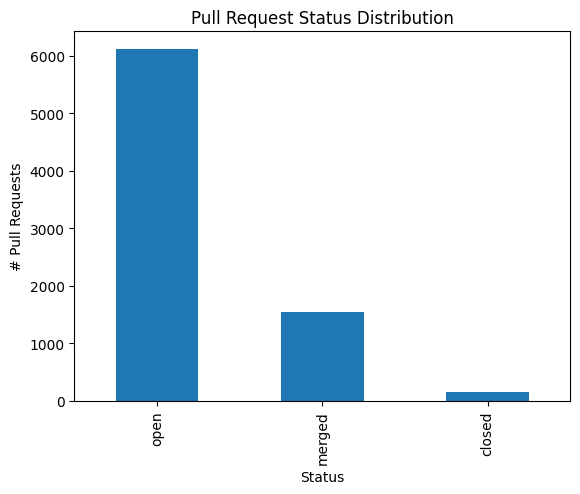

<Axes: ylabel='count'>

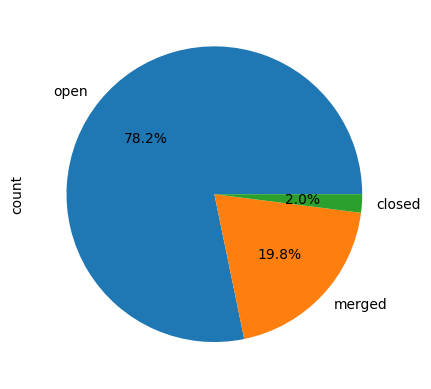

In [42]:

import matplotlib.pyplot as plt

# Plot the status distribution
status_distribution = df['status'].value_counts()
status_distribution.plot(kind='bar')
# Add title and labels
plt.title('Pull Request Status Distribution')
plt.xlabel('Status')
plt.ylabel('# Pull Requests')
plt.show()

# show pie chart
status_distribution.plot.pie(autopct='%1.1f%%')